# Lending Club Analysis Using AutoML

In this tutorial, we will go through a step-by-step workflow to build models using AML to determine loan deliquency. We will make predictions based only on the information available at the time the loan was issued.  The data for this exercise come from the public Lending Club data set, a description can be found [here](https://www.kaggle.com/pragyanbo/a-hitchhiker-s-guide-to-lending-club-loan-data/notebook).

We will highlight data cleaning and feature engineering that will improve model performance.

## Workflow

1. Start H2O-3 cluster
2. Import data
3. Train default models using H2O's AutoML
4. Feature engineering to improve model performance
5. Train models using transformed data with AutoML
6. Stop H2O-3 cluster

# Step 1 (of 6). Start H2O Cluster

In [2]:
import h2o
h2o.init(max_mem_size = "6g")

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,15 hours 43 mins
H2O cluster timezone:,America/Denver
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,1 month and 20 days
H2O cluster name:,H2O_from_python_dwhiting_8e4dyf
H2O cluster total nodes:,1
H2O cluster free memory:,3.936 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


# Step 2 (of 6). Import Data

This exploration of H2O will use a version of the Lending Club Loan Data that can be found on [Kaggle](https://www.kaggle.com/wendykan/lending-club-loan-data). This data consists of 15 variables:

|  Id   | Column Name | Description |
| --- | ----------- | ----------- |
|   1 | loan_amnt   | Requested loan amount (US dollars) |
|   2 | term        | Loan term length (months) |
|   3 | int_rate    | Recommended interest rate |
|   4 | emp_length  | Employment length (years) |
|   5 | home_ownership| Housing status |
|   6 | annual_inc  | Annual income (US dollars) |
|   7 | purpose     | Purpose for the loan |
|   8 | addr_state  | State of residence |
|   9 | dti         | Debt to income ratio |
|  10 | delinq_2yrs | Number of delinquencies in the past 2 years |
|  11 | revol_util  | Percent of revolving credit line utilized |
|  12 | total_acc   | Number of active accounts |
|  13 | bad_loan    | Bad loan indicator |
|  14 | longest_credit_length | Age of oldest active account |
|  15 | verification_status | Income verification status |

In [137]:
# https://s3-us-west-2.amazonaws.com/h2o-tutorials/data/topics/data/automl/loan.csv
loans = h2o.import_file("../../data/automl/loan.csv")
loans["bad_loan"] = loans["bad_loan"].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [138]:
loans.describe()

Rows:163987
Cols:15




,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
type,int,enum,real,int,enum,real,enum,enum,real,int,real,int,enum,int,enum
mins,500.0,,5.42,0.0,,1896.0,,,0.0,0.0,0.0,1.0,,0.0,
mean,13074.169141456336,,13.715904065566173,5.68435293299533,,71915.67051974901,,,15.881530121290117,0.2273570060625282,54.07917280242258,24.579733834274638,,14.854273655448353,
maxs,35000.0,,26.06,10.0,,7141778.0,,,39.99,29.0,150.70000000000002,118.0,,65.0,
sigma,7993.556188734649,,4.391939870545795,3.6106637311002365,,59070.915654918244,,,7.587668224192549,0.6941679229284182,25.285366766770505,11.685190365910659,,6.947732922546696,
zeros,0,,0,14248,,0,,,270,139459,1562,0,,11,
missing,0,0,0,5804,0,4,0,0,0,29,193,29,0,29,0
0,5000.0,36 months,10.65,10.0,RENT,24000.0,credit_card,AZ,27.65,0.0,83.7,9.0,0,26.0,verified
1,2500.0,60 months,15.27,0.0,RENT,30000.0,car,GA,1.0,0.0,9.4,4.0,1,12.0,verified
2,2400.0,36 months,15.96,10.0,RENT,12252.0,small_business,IL,8.72,0.0,98.5,10.0,0,10.0,not verified


# Step 3 (of 6). Train Default Models with AutoML

Start by splitting the data into train and test sets

In [139]:
train, test = loans.split_frame(seed=1234, ratios=[0.75])

and train 6 models using all but the `DeepLearning` algorithms

In [140]:
# Set target and predictor variables
y = "bad_loan"
x = train.col_names
x.remove(y)
x.remove("int_rate")

# Use Auto ML to train models
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_models = 6, exclude_algos = ['DeepLearning'])
aml.train(x = x, y = y, training_frame = train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


Print out a leaderboard with the 6 best models and two ensembles: a stacked ensemble of all models, and a best-of-family stacked ensemble:

In [141]:
print(aml.leaderboard)

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190809_162540,0.683294,0.445457,0.367797,0.37423,0.140048
StackedEnsemble_BestOfFamily_AutoML_20190809_162540,0.683033,0.44562,0.368354,0.374313,0.14011
GBM_1_AutoML_20190809_162540,0.6795,0.445064,0.371925,0.374226,0.140045
XGBoost_1_AutoML_20190809_162540,0.678888,0.445369,0.369363,0.374436,0.140202
XGBoost_3_AutoML_20190809_162540,0.678097,0.446038,0.372483,0.374376,0.140157
XGBoost_2_AutoML_20190809_162540,0.674272,0.447163,0.373644,0.375226,0.140795
GLM_grid_1_AutoML_20190809_162540_model_1,0.673427,0.44771,0.373854,0.374975,0.140606
DRF_1_AutoML_20190809_162540,0.658498,0.454956,0.385202,0.377771,0.142711


As is often the case, the stacked ensemble models are among the best in performance.

## Examine the Top Model

The `aml.leader` call automatically pulls out the top model

In [142]:
top_model = aml.leader

Details for training and cross-validated data are contained in `aml.leader`

In [143]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20190809_162540
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.12115329547964772
RMSE: 0.3480708196325106
LogLoss: 0.3917219754414419
Null degrees of freedom: 123061
Residual degrees of freedom: 123055
Null deviance: 117105.43670854249
Residual deviance: 96412.17948354944
AIC: 96426.17948354944
AUC: 0.826719683698346
pr_auc: 0.539553937647294
Gini: 0.6534393673966921
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2151940545532514: 


,0,1,Error,Rate
0,83588.0,16963.0,0.1687,(16963.0/100551.0)
1,8469.0,14042.0,0.3762,(8469.0/22511.0)
Total,92057.0,31005.0,0.2067,(25432.0/123062.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2151941,0.5247776,236.0
max f2,0.1533649,0.6507052,297.0
max f0point5,0.2944863,0.5256523,178.0
max accuracy,0.3683753,0.8400562,135.0
max precision,0.8788145,1.0,0.0
max recall,0.0845053,1.0,387.0
max specificity,0.8788145,1.0,0.0
max absolute_mcc,0.2151941,0.4052634,236.0
max min_per_class_accuracy,0.1834574,0.7425703,267.0
max mean_per_class_accuracy,0.1745969,0.7441265,275.0


Gains/Lift Table: Avg response rate: 18.29 %, avg score: 18.40 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100031,0.5860325,4.9738095,4.9738095,0.9098294,0.6569577,0.9098294,0.6569577,0.0497535,0.0497535,397.3809537,397.3809537
,2,0.0200062,0.5192407,4.2010927,4.5874511,0.7684809,0.5491623,0.8391552,0.6030600,0.0420239,0.0917774,320.1092698,358.7451117
,3,0.0300011,0.4728962,3.7333900,4.3029183,0.6829268,0.4954807,0.7871073,0.5672197,0.0373151,0.1290924,273.3389963,330.2918284
,4,0.0400042,0.4403359,3.3662032,4.0686920,0.6157595,0.4565454,0.7442616,0.5395455,0.0336724,0.1627649,236.6203240,306.8691955
,5,0.0500073,0.4137444,3.3040306,3.9157348,0.6043867,0.4266070,0.7162821,0.5169541,0.0330505,0.1958154,230.4030621,291.5734837
,6,0.1000065,0.3240525,2.7053880,3.3106106,0.4948805,0.3642031,0.6055903,0.4405848,0.1352672,0.3310826,170.5388022,231.0610603
,7,0.1500057,0.2740858,2.2975808,2.9729523,0.4202828,0.2969832,0.5438245,0.3927202,0.1148772,0.4459598,129.7580763,197.2952282
,8,0.2000049,0.2398144,1.8728926,2.6979485,0.3425971,0.2556922,0.4935197,0.3584646,0.0936431,0.5396029,87.2892594,169.7948534
,9,0.3000033,0.1971258,1.4659738,2.2873014,0.2681619,0.2165106,0.4184024,0.3111479,0.1465950,0.6861979,46.5973805,128.7301414
,10,0.4000016,0.1690381,1.1110305,1.9932396,0.2032342,0.1822437,0.3646115,0.2789225,0.1111012,0.7972991,11.1030450,99.3239647




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.1400481614822642
RMSE: 0.37423009163115706
LogLoss: 0.44545681268239234
Null degrees of freedom: 123061
Residual degrees of freedom: 123055
Null deviance: 117106.60132581186
Residual deviance: 109637.61256464117
AIC: 109651.61256464117
AUC: 0.6832937346105638
pr_auc: 0.32283066986621195
Gini: 0.3665874692211275
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17423538385317197: 


,0,1,Error,Rate
0,66854.0,33697.0,0.3351,(33697.0/100551.0)
1,9015.0,13496.0,0.4005,(9015.0/22511.0)
Total,75869.0,47193.0,0.3471,(42712.0/123062.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1742354,0.3872375,274.0
max f2,0.1175858,0.5535826,343.0
max f0point5,0.2582936,0.3496303,198.0
max accuracy,0.6320746,0.8175554,27.0
max precision,0.8320725,0.8333333,0.0
max recall,0.0728713,1.0,398.0
max specificity,0.8320725,0.9999901,0.0
max absolute_mcc,0.2027889,0.2127926,243.0
max min_per_class_accuracy,0.1663758,0.6307545,282.0
max mean_per_class_accuracy,0.1692017,0.6327295,279.0


Gains/Lift Table: Avg response rate: 18.29 %, avg score: 18.29 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100031,0.5594892,2.8110906,2.8110906,0.5142161,0.6255723,0.5142161,0.6255723,0.0281196,0.0281196,181.1090569,181.1090569
,2,0.0200062,0.4992681,2.4691412,2.6401159,0.4516653,0.5267348,0.4829407,0.5761536,0.0246990,0.0528186,146.9141163,164.0115866
,3,0.0300011,0.4576850,2.3867029,2.5556906,0.4365854,0.4769487,0.4674973,0.5431032,0.0238550,0.0766736,138.6702869,155.5690626
,4,0.0400042,0.4272582,2.2026871,2.4674218,0.4029245,0.4419622,0.4513508,0.5178128,0.0220337,0.0987073,120.2687081,146.7421813
,5,0.0500073,0.4019715,2.0428146,2.3824866,0.3736799,0.4141753,0.4358141,0.4970819,0.0204345,0.1191418,104.2814631,138.2486578
,6,0.1000065,0.3178671,1.9235353,2.1530296,0.3518609,0.3550627,0.3938409,0.4260781,0.0961752,0.2153170,92.3535326,115.3029598
,7,0.1500057,0.2694215,1.6543292,1.9868051,0.3026166,0.2917142,0.3634345,0.3812925,0.0827151,0.2980321,65.4329227,98.6805146
,8,0.2000049,0.2378454,1.5041780,1.8661533,0.2751503,0.2527747,0.3413643,0.3491644,0.0752077,0.3732397,50.4177971,86.6153254
,9,0.3000033,0.1971145,1.3158225,1.6827147,0.2406956,0.2159104,0.3078090,0.3047476,0.1315801,0.5048199,31.5822549,68.2714655
,10,0.4000016,0.1698404,1.1123632,1.5401297,0.2034780,0.1826700,0.2817268,0.2742288,0.1112345,0.6160544,11.2363154,54.0129676


To get details for the test data, use the `model_performance` call

In [204]:
perf = aml.leader.model_performance(test_data=test)
perf


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.13981753949326745
RMSE: 0.3739218360744227
LogLoss: 0.4447534541229015
Null degrees of freedom: 40924
Residual degrees of freedom: 40918
Null deviance: 39000.482887089915
Residual deviance: 36403.07021995949
AIC: 36417.07021995949
AUC: 0.6866339097294403
pr_auc: 0.32862267862066386
Gini: 0.37326781945888055
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17581607858636789: 


,0,1,Error,Rate
0,22415.0,11005.0,0.3293,(11005.0/33420.0)
1,3033.0,4472.0,0.4041,(3033.0/7505.0)
Total,25448.0,15477.0,0.343,(14038.0/40925.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1758161,0.3891741,267.0
max f2,0.1199526,0.5570104,338.0
max f0point5,0.2521982,0.3556126,198.0
max accuracy,0.5131068,0.8175932,60.0
max precision,0.8857001,1.0,0.0
max recall,0.0715652,1.0,399.0
max specificity,0.8857001,1.0,0.0
max absolute_mcc,0.2027897,0.2171205,240.0
max min_per_class_accuracy,0.1669937,0.6314482,277.0
max mean_per_class_accuracy,0.1707712,0.6337967,273.0


Gains/Lift Table: Avg response rate: 18.34 %, avg score: 18.31 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100183,0.5586579,2.8462163,2.8462163,0.5219512,0.6234970,0.5219512,0.6234970,0.0285143,0.0285143,184.6216344,184.6216344
,2,0.0200122,0.5004216,2.7731797,2.8097426,0.5085575,0.5284353,0.5152625,0.5760242,0.0277149,0.0562292,177.3179738,180.9742630
,3,0.0300061,0.4609375,2.4265323,2.6821099,0.4449878,0.4792291,0.4918567,0.5437854,0.0242505,0.0804797,142.6532271,168.2109864
,4,0.04,0.4280935,2.1065500,2.5383078,0.3863081,0.4433676,0.4654856,0.5186963,0.0210526,0.1015323,110.6549994,153.8307795
,5,0.0500183,0.4017733,2.0216116,2.4348171,0.3707317,0.4145474,0.4465071,0.4978360,0.0202532,0.1217855,102.1611609,143.4817108
,6,0.1000122,0.3176898,1.9722596,2.2035949,0.3616813,0.3548766,0.4041046,0.4263737,0.0986009,0.2203864,97.2259614,120.3594867
,7,0.1500061,0.2693419,1.6311120,2.0127983,0.2991202,0.2917742,0.3691155,0.3815145,0.0815456,0.3019320,63.1112005,101.2798331
,8,0.2,0.2385570,1.5031817,1.8854097,0.2756598,0.2532137,0.3457544,0.3494432,0.0751499,0.3770819,50.3181652,88.5409727
,9,0.3000122,0.1968269,1.2923138,1.6876950,0.2369900,0.2158854,0.3094967,0.3049203,0.1292472,0.5063291,29.2313797,68.7694982
,10,0.4,0.1703743,1.1180580,1.5453031,0.2050342,0.1826499,0.2833842,0.2743565,0.1117921,0.6181213,11.8057984,54.5303131


In [205]:
print("AUC: train = {:.4f}, xval = {:.4f}, test = {:.4f}" \
      .format(aml.leader.auc(train = True), aml.leader.auc(xval = True), perf.auc()))
print("Logloss: train = {:.4f}, xval = {:.4f}, test = {:.4f}" \
      .format(aml.leader.logloss(train = True), aml.leader.logloss(xval = True), perf.logloss()))

AUC: train = 0.8267, xval = 0.6833, test = 0.6866
Logloss: train = 0.3917, xval = 0.4455, test = 0.4448


## Examine a Selected Model

We demonstrate how to select any model from the leaderboard below.

In [145]:
aml.leaderboard

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190809_162540,0.683294,0.445457,0.367797,0.37423,0.140048
StackedEnsemble_BestOfFamily_AutoML_20190809_162540,0.683033,0.44562,0.368354,0.374313,0.14011
GBM_1_AutoML_20190809_162540,0.6795,0.445064,0.371925,0.374226,0.140045
XGBoost_1_AutoML_20190809_162540,0.678888,0.445369,0.369363,0.374436,0.140202
XGBoost_3_AutoML_20190809_162540,0.678097,0.446038,0.372483,0.374376,0.140157
XGBoost_2_AutoML_20190809_162540,0.674272,0.447163,0.373644,0.375226,0.140795
GLM_grid_1_AutoML_20190809_162540_model_1,0.673427,0.44771,0.373854,0.374975,0.140606
DRF_1_AutoML_20190809_162540,0.658498,0.454956,0.385202,0.377771,0.142711


We can select an specified model from the leaderboard by indicating its position. The following code will select the best model that is not a stacked ensemble:

In [207]:
m = aml.leaderboard['model_id'].grep("StackedEnsemble", invert=True).min()
select_model = h2o.get_model(aml.leaderboard[int(m),'model_id'])

We can look at performance with the selected model just as we did with the top model.

In [208]:
select_model

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_20190809_162540


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.13291337273488157
RMSE: 0.3645728634098835
LogLoss: 0.4247708165064435
Mean Per-Class Error: 0.33330235944788955
AUC: 0.7303308220861244
pr_auc: 0.4058343768379885
Gini: 0.46066164417224886
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22542114786172546: 


,0,1,Error,Rate
0,79645.0,20906.0,0.2079,(20906.0/100551.0)
1,10727.0,11784.0,0.4765,(10727.0/22511.0)
Total,90372.0,32690.0,0.257,(31633.0/123062.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2254211,0.4269488,204.0
max f2,0.1272951,0.5737896,308.0
max f0point5,0.3115097,0.4202113,139.0
max accuracy,0.4197410,0.8247956,79.0
max precision,0.8403577,1.0,0.0
max recall,0.0394787,1.0,396.0
max specificity,0.8403577,1.0,0.0
max absolute_mcc,0.2400098,0.2803765,191.0
max min_per_class_accuracy,0.1847882,0.6658967,244.0
max mean_per_class_accuracy,0.1869548,0.6666976,242.0


Gains/Lift Table: Avg response rate: 18.29 %, avg score: 18.32 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100031,0.5042576,4.0767475,4.0767475,0.7457352,0.5599777,0.7457352,0.5599777,0.0407801,0.0407801,307.6747460,307.6747460
,2,0.0200062,0.4594842,3.2240944,3.6504209,0.5897644,0.4800902,0.6677498,0.5200340,0.0322509,0.0730310,222.4094396,265.0420928
,3,0.0300011,0.4298388,2.9422669,3.4144974,0.5382114,0.4434445,0.6245937,0.4945180,0.0294078,0.1024388,194.2266852,241.4497441
,4,0.0400042,0.4060671,2.7622407,3.2514001,0.5052803,0.4177086,0.5947593,0.4753117,0.0276309,0.1300697,176.2240653,225.1400121
,5,0.0500073,0.3871626,2.6512181,3.1313442,0.4849716,0.3962212,0.5727982,0.4594910,0.0265204,0.1565901,165.1218119,213.1344215
,6,0.1000065,0.3219349,2.1829683,2.6571948,0.3993174,0.3511316,0.4860648,0.4053157,0.1091466,0.2657368,118.2968266,165.7194771
,7,0.1500057,0.2815025,1.8213614,2.3785987,0.3331708,0.3002627,0.4351029,0.3702999,0.0910666,0.3568033,82.1361394,137.8598738
,8,0.2000049,0.2526112,1.5512668,2.1717742,0.2837640,0.2663910,0.3972697,0.3443237,0.0775621,0.4343654,55.1266826,117.1774163
,9,0.3000033,0.2126497,1.2878358,1.8771360,0.2355761,0.2314778,0.3433733,0.3067095,0.1287815,0.5631469,28.7835776,87.7136015
,10,0.4000016,0.1826723,1.0897072,1.6802828,0.1993337,0.1970406,0.3073641,0.2792928,0.1089689,0.6721159,8.9707195,68.0282809




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.14004529613705483
RMSE: 0.3742262632914142
LogLoss: 0.4450644856474346
Mean Per-Class Error: 0.3704113507688005
AUC: 0.6794998954278209
pr_auc: 0.3172610273859076
Gini: 0.3589997908556417
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19248465135358267: 


,0,1,Error,Rate
0,68570.0,31981.0,0.3181,(31981.0/100551.0)
1,9585.0,12926.0,0.4258,(9585.0/22511.0)
Total,78155.0,44907.0,0.3378,(41566.0/123062.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1924847,0.3834584,235.0
max f2,0.1147663,0.5509777,323.0
max f0point5,0.2687368,0.3464343,168.0
max accuracy,0.6076727,0.8172547,16.0
max precision,0.7979256,1.0,0.0
max recall,0.0309875,1.0,399.0
max specificity,0.7979256,1.0,0.0
max absolute_mcc,0.2196367,0.2080357,207.0
max min_per_class_accuracy,0.1783467,0.6292130,250.0
max mean_per_class_accuracy,0.1746230,0.6295886,254.0


Gains/Lift Table: Avg response rate: 18.29 %, avg score: 18.29 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100031,0.5004928,2.6023682,2.6023682,0.4760357,0.5532510,0.4760357,0.5532510,0.0260317,0.0260317,160.2368204,160.2368204
,2,0.0200062,0.4544366,2.4913457,2.5468569,0.4557271,0.4741688,0.4658814,0.5137099,0.0249211,0.0509529,149.1345670,154.6856937
,3,0.0300011,0.4255485,2.3067017,2.4668485,0.4219512,0.4390791,0.4512459,0.4888464,0.0230554,0.0740083,130.6701656,146.6848542
,4,0.0400042,0.4027860,2.2115689,2.4030157,0.4045491,0.4138633,0.4395694,0.4700968,0.0221225,0.0961308,121.1568883,140.3015663
,5,0.0500073,0.3839916,2.2915051,2.3807099,0.4191714,0.3934086,0.4354891,0.4547567,0.0229221,0.1190529,129.1505108,138.0709928
,6,0.1000065,0.3204976,1.8977697,2.1392594,0.3471477,0.3490833,0.3913220,0.4019243,0.0948869,0.2139399,89.7769726,113.9259448
,7,0.1500057,0.2813159,1.6303406,1.9696290,0.2982285,0.2995201,0.3602925,0.3677914,0.0815157,0.2954556,63.0340565,96.9629010
,8,0.2000049,0.2526951,1.5130627,1.8554921,0.2767756,0.2663425,0.3394141,0.3424302,0.0756519,0.3711075,51.3062661,85.5492060
,9,0.3000033,0.2123973,1.2967205,1.6692399,0.2372014,0.2311342,0.3053441,0.3053325,0.1296699,0.5007774,29.6720466,66.9239907
,10,0.4000016,0.1825631,1.0901514,1.5244707,0.1994149,0.1968592,0.2788624,0.2782148,0.1090134,0.6097908,9.0151430,52.4470728



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.6432450,0.0174590,0.6063056,0.6566855,0.671136,0.6221355,0.6599626
auc,0.6796409,0.0024435,0.6772523,0.6855043,0.6755881,0.678699,0.6811607
err,0.3567549,0.0174590,0.3936944,0.3433145,0.3288640,0.3778645,0.3400374
err_count,8780.6,429.7575,9690.0,8450.0,8094.0,9300.0,8369.0
f0point5,0.3152068,0.0033204,0.3082449,0.3164223,0.3208335,0.3114827,0.3190504
f1,0.3843272,0.0013654,0.3853863,0.3842903,0.3807192,0.3863816,0.3848585
f2,0.4929825,0.0117880,0.5140266,0.4892212,0.4680915,0.5087042,0.4848687
lift_top_group,2.575858,0.0761591,2.7541387,2.644316,2.4789197,2.479573,2.5223434
logloss,0.4450645,0.0032438,0.4505163,0.4374712,0.4466668,0.4480845,0.4425837
max_per_class_error,0.4104134,0.0148862,0.4062843,0.4019052,0.4473567,0.3829904,0.4135305


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-08-09 16:35:46,13.551 sec,0.0,0.3866042,0.4757985,0.5,0.0,1.0,0.8170759
,2019-08-09 16:35:46,13.679 sec,5.0,0.3788228,0.4569773,0.6887145,0.3431482,3.2640625,0.3290943
,2019-08-09 16:35:46,13.838 sec,10.0,0.3749243,0.4480376,0.6980768,0.3557118,3.4639031,0.3132730
,2019-08-09 16:35:46,14.002 sec,15.0,0.3722562,0.4420540,0.7027369,0.3644416,3.6370982,0.2979880
,2019-08-09 16:35:46,14.163 sec,20.0,0.3704906,0.4380444,0.7077085,0.3713763,3.7703253,0.2994669
,2019-08-09 16:35:46,14.338 sec,25.0,0.3690293,0.4347561,0.7123656,0.3787356,3.8058525,0.2968585
,2019-08-09 16:35:47,14.498 sec,30.0,0.3679367,0.4323049,0.7163146,0.3845538,3.8813478,0.2796477
,2019-08-09 16:35:47,14.660 sec,35.0,0.3670078,0.4301987,0.7202959,0.3898166,3.8724660,0.3029936
,2019-08-09 16:35:47,14.815 sec,40.0,0.3662707,0.4284879,0.7236106,0.3940996,3.9213159,0.3024573
,2019-08-09 16:35:47,14.972 sec,45.0,0.3655391,0.4269068,0.7261493,0.3993499,4.0056930,0.2811510


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
addr_state,1936.1915283,1.0,0.2027364
term,1887.4870605,0.9748452,0.1976366
annual_inc,1225.1881104,0.6327825,0.1282880
revol_util,1020.9816895,0.5273144,0.1069058
dti,943.7391357,0.4874203,0.0988178
purpose,756.5767822,0.3907551,0.0792203
loan_amnt,566.2157593,0.2924379,0.0592878
emp_length,277.0203247,0.1430749,0.0290065
total_acc,246.2066040,0.1271603,0.0257800
longest_credit_length,237.2908173,0.1225554,0.0248465


and performance on test data

In [209]:
select_perf = select_model.model_performance(test_data=test)
select_perf


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.1398713964765848
RMSE: 0.3739938455062928
LogLoss: 0.4443729255366117
Mean Per-Class Error: 0.3658939920762978
AUC: 0.6836106688898005
pr_auc: 0.3222997213245483
Gini: 0.367221337779601
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1851689211721298: 


,0,1,Error,Rate
0,21824.0,11596.0,0.347,(11596.0/33420.0)
1,2888.0,4617.0,0.3848,(2888.0/7505.0)
Total,24712.0,16213.0,0.3539,(14484.0/40925.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1851689,0.3893246,243.0
max f2,0.1188924,0.5563182,316.0
max f0point5,0.2681546,0.3517065,166.0
max accuracy,0.4566878,0.8169334,57.0
max precision,0.8577351,1.0,0.0
max recall,0.0310456,1.0,399.0
max specificity,0.8577351,1.0,0.0
max absolute_mcc,0.2048728,0.2122899,223.0
max min_per_class_accuracy,0.1796356,0.6317122,249.0
max mean_per_class_accuracy,0.1851689,0.6341060,243.0


Gains/Lift Table: Avg response rate: 18.34 %, avg score: 18.31 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100183,0.4989193,2.6600153,2.6600153,0.4878049,0.5517604,0.4878049,0.5517604,0.0266489,0.0266489,166.0015274,166.0015274
,2,0.0200122,0.4552835,2.8665079,2.7631355,0.5256724,0.4756856,0.5067155,0.5137695,0.0286476,0.0552965,186.6507903,176.3135525
,3,0.0300061,0.4244702,2.3865345,2.6377041,0.4376528,0.4390883,0.4837134,0.4888960,0.0238508,0.0791472,138.6534486,163.7704071
,4,0.04,0.4019499,2.0532196,2.4916722,0.3765281,0.4128601,0.4569334,0.4698987,0.0205197,0.0996669,105.3219614,149.1672219
,5,0.0500183,0.3832927,1.9817114,2.3895306,0.3634146,0.3916272,0.4382022,0.4542214,0.0198534,0.1195203,98.1711379,138.9530575
,6,0.1000122,0.3198871,1.8656510,2.1276548,0.3421310,0.3490580,0.3901784,0.4016525,0.0932712,0.2127915,86.5650987,112.7654778
,7,0.1500061,0.2802386,1.7243946,1.9932566,0.3162268,0.2988041,0.3655318,0.3673753,0.0862092,0.2990007,72.4394555,99.3256600
,8,0.2,0.2524780,1.5111773,1.8727515,0.2771261,0.2655953,0.3434331,0.3419334,0.0755496,0.3745503,51.1177299,87.2751499
,9,0.3000122,0.2130521,1.3056366,1.6836978,0.2394332,0.2313585,0.3087636,0.3050721,0.1305796,0.5051299,30.5636620,68.3697810
,10,0.4,0.1834758,1.1380471,1.5473018,0.2086999,0.1977540,0.2837508,0.2782459,0.1137908,0.6189207,13.8047102,54.7301799


A summary is then given by

In [210]:
print("AUC: train = {:.4f}, xval = {:.4f}, test = {:.4f}" \
      .format(select_model.auc(train = True), select_model.auc(xval = True), select_perf.auc()))
print("Logloss: train = {:.4f}, xval = {:.4f}, test = {:.4f}" \
      .format(select_model.logloss(train = True), select_model.logloss(xval = True), select_perf.logloss()))

AUC: train = 0.7303, xval = 0.6795, test = 0.6836
Logloss: train = 0.4248, xval = 0.4451, test = 0.4444


We next look at variable importance plots for our selected model.

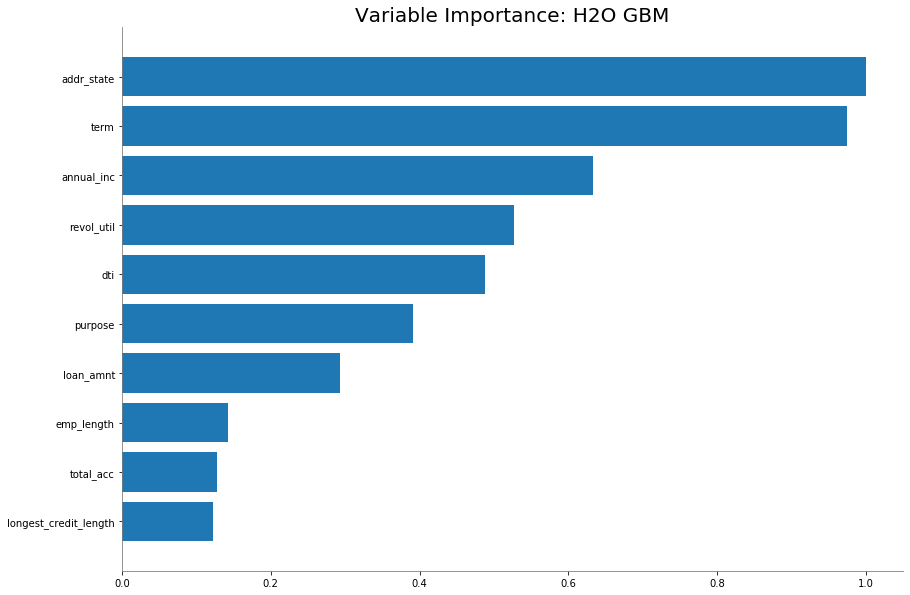

In [203]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

select_model.varimp_plot()

Note that `addr_state`, a high-cardinality categorical variable, is the most important variable. We will next try some feature engineering to see whether we can improve this model's overall performance.

# Step 4 (of 6). Feature Engineering to Improve Model Performance

The goal of this section is to improve upon these predictors through a number of feature engineering steps. In particular, we will perform four feature engineering tasks on select variables:

**Creating Target Encoding** 
   - Loan Purpose
   - State of Residence

**Separating Typical from Extreme**
   - Loan Amount
   - Annual Income
   - Debt to Income Ratio
   - Number of Delinquencies in the Past 2 Years
   - Revolving Credit Line Utilized
   - Number of Credit Lines
   - Longest Credit Length

**Creating Indicator Functions**
   - Term
   - Income Verification Status
   - Employment Length (Missing Value)

**Combining Categories** 
   - Home Ownership

## 1. Creating Target Encoding

### Cross Validation with Target Encoding

Some of the engineered features will use [cross-validated mean target encoding](https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/categorical-predictors/target_encoding.md) of categorical predictors since one-hot encodings can lead to overfitting of infrequent categories.

To achieve this goal, we will first create soft partitions using H2OFrame's [`kfold_column`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=kfold_column#h2o.frame.H2OFrame.kfold_column) function, then calculate summary statistics using H2O's [`group_by`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html#groupby) function, and finally join these engineered features using H2OFrame's [`merge`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=merge#h2o.frame.H2OFrame.merge).

In [211]:
y = "bad_loan"
x_orig = train.col_names
x_orig.remove(y)
x_orig.remove("int_rate")

x_trans = x_orig.copy()

In [212]:
cv_nfolds = 5
cv_seed = 1234
train["cv_fold"] = train.kfold_column(n_folds = cv_nfolds, seed = cv_seed)

In [213]:
train["cv_fold"].table()

cv_fold,Count
0,24674
1,24621
2,24740
3,24478
4,24549


In [214]:
import numpy as np
import pandas as pd

In [215]:
def logit(p):
    return np.log(p) - np.log(1 - p)

In [216]:
def mean_target(data, x, y = "bad_loan"):
    grouped_data = data[[x, y]].group_by([x])
    stats = grouped_data.count(na = "ignore").mean(na = "ignore")
    return stats.get_frame().as_data_frame()

In [217]:
def mean_target_encoding(data, x, y = "bad_loan", fold_column = "cv_fold", prior_mean = 0.183, prior_count = 1):
    """
    Creates target encoding for binary target
    data (H2OFrame) : data set
    x (string) : categorical predictor column name
    y (string) : binary target column name
    fold_column (string) : cross-validation fold column name
    prior_mean (float) : proportion of 1s in the target column
    prior_count (positive number) : weight to give to prior_mean
    """ 
    grouped_data = data[[x, fold_column, y]].group_by([x, fold_column])
    grouped_data.sum(na = "ignore").count(na = "ignore")
    df = grouped_data.get_frame().as_data_frame()
    df_list = []
    nfold = int(data[fold_column].max()) + 1
    for j in range(0, nfold):
        te_x = "te_{}".format(x)
        sum_y = "sum_{}".format(y)
        oof = df.loc[df[fold_column] != j, [x, sum_y, "nrow"]]
        stats = oof.groupby([x]).sum()
        stats[x] = stats.index
        stats[fold_column] = j
        p = (stats[sum_y] + (prior_count * prior_mean)) / (stats["nrow"] + prior_count)
        stats[te_x] = logit(p)
        df_list.append(stats[[x, fold_column, te_x]])
    return h2o.H2OFrame(pd.concat(df_list))

### 1.1. Creating Target Encoding for Loan Purpose

Given that there is a high concentration of loans for debt consolidation (56.87%), a sizable number for credit card (18.78%), and the remaining 24.35% loans are spread amongst 12 other purposes, we will use mean target encoding to avoid overfitting the later group.

In [218]:
tbl = train["purpose"].table().as_data_frame()
tbl["Percent"] = np.round((100 * tbl["Count"]/train.nrows), 2)
tbl = tbl.sort_values(by = "Count", ascending = 0)
tbl = tbl.reset_index(drop = True)
print(tbl)

               purpose  Count  Percent
0   debt_consolidation  69976    56.86
1          credit_card  23082    18.76
2                other   7916     6.43
3     home_improvement   7346     5.97
4       major_purchase   3535     2.87
5       small_business   2912     2.37
6                  car   2126     1.73
7              medical   1540     1.25
8              wedding   1320     1.07
9               moving   1091     0.89
10               house    937     0.76
11            vacation    834     0.68
12         educational    303     0.25
13    renewable_energy    144     0.12


In [219]:
df = mean_target(train, "purpose")

df = df.sort_values(by = "mean_bad_loan", ascending = 0)
df = df.reset_index(drop = True)
df

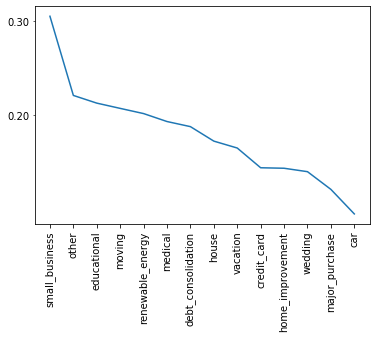

In [221]:
plt.xticks(rotation = 90)
plt.yscale("logit")
plt.plot(df["purpose"], df["mean_bad_loan"])

In [222]:
te_purpose = mean_target_encoding(train, "purpose")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [223]:
train = train.merge(te_purpose, all_x = True)

Replace `purpose` with target encoded `te_purpose`

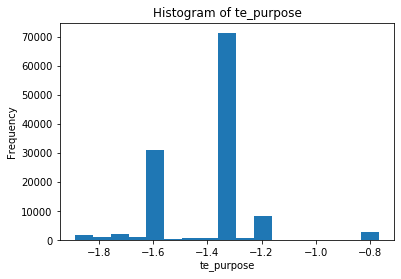

In [225]:
x_trans.remove("purpose")
x_trans.append("te_purpose")

train["te_purpose"].hist()

### 1.2. Target Encoding for State of Residence

We will also use a mean target encoding for *state of residence* for a reason similar to that for *purpose*.

In [226]:
tbl = train["addr_state"].table().as_data_frame()
tbl["Percent"] = np.round((100 * tbl["Count"]/train.nrows), 2)
tbl = tbl.sort_values(by = "Count", ascending = 0)
tbl = tbl.reset_index(drop = True)
print(tbl[0:5])

  addr_state  Count  Percent
0         CA  21493    17.47
1         NY  10699     8.69
2         TX   9188     7.47
3         FL   8554     6.95
4         NJ   4755     3.86


In [227]:
df = mean_target(train, "addr_state")

df = df.sort_values(by = "mean_bad_loan", ascending = 0)
df = df.reset_index(drop = True)
print(df[0:5])

  addr_state  nrow  mean_bad_loan
0         NE     8       0.625000
1         IA     7       0.285714
2         MS   124       0.233871
3         NV  1764       0.231859
4         TN   977       0.220061


In [228]:
print(df[45:50])

   addr_state  nrow  mean_bad_loan
45         WV   530       0.135849
46         ID     8       0.125000
47         DC   452       0.110619
48         WY   289       0.096886
49         ME     3       0.000000


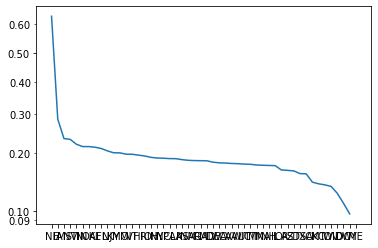

In [229]:
plt.yscale("logit")
plt.plot(df["addr_state"], df["mean_bad_loan"])

In [230]:
te_addr_state = mean_target_encoding(train, "addr_state", prior_count = 30)

Parse progress: |█████████████████████████████████████████████████████████| 100%


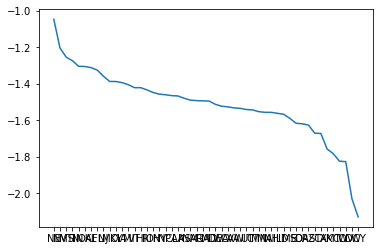

In [231]:
grouped_data = te_addr_state[["addr_state", "te_addr_state"]].group_by(["addr_state"])
df = grouped_data.count(na = "ignore").mean(na = "ignore").get_frame().as_data_frame()

df = df.sort_values(by = "mean_te_addr_state", ascending = 0)
df = df.reset_index(drop = True)

plt.plot(df["addr_state"], df["mean_te_addr_state"])

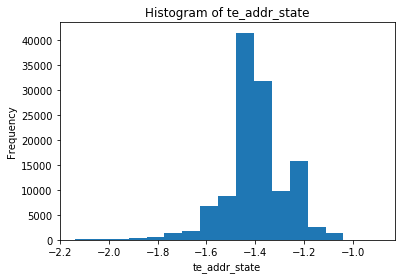

In [233]:
train = train.merge(te_addr_state, all_x = True)

x_trans.remove("addr_state")
x_trans.append("te_addr_state")

train["te_addr_state"].hist()

## 2. Separating Typical from Extreme

### 2.1. Separating Typical from Extreme Loan Amount

After binning `loan_amt` using H2OFrame's [`cut`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=cut#h2o.frame.H2OFrame.cut) function and looking at the fraction of bad loans on a logit scale, we see that the chance of a bad loan roughly increases linearly in loan amount from \\$5,000 to \\$30,000 and is relatively flat below \\$5,000 and above \\$30,000. To reflect this finding in the modeling, we will replace the original `loan_amnt` measure with two derived measures:

\begin{eqnarray}
\text{loan_amnt_core} & = & \max(5000, \min(\text{loan_amnt}, 30000)) \\
\text{loan_amnt_diff} & = & \text{loan_amnt} - \text{loan_amnt_core}
\end{eqnarray}

In [234]:
train["loan_amnt"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,loan_amntQuantiles
0,500
0.05,3000
0.25,7000
0.5,11400
0.75,18000
0.95,30000
1,35000


In [236]:
breaks = np.linspace(0, 35000, 8).tolist()
train["loan_amnt_cat"] = train["loan_amnt"].cut(breaks = breaks)

df = mean_target(train, "loan_amnt_cat")

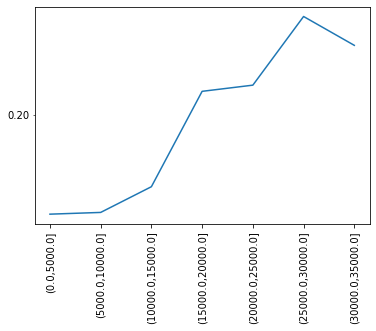

In [237]:
plt.xticks(rotation = 90)
plt.yscale("logit")
plt.plot(df["loan_amnt_cat"], df["mean_bad_loan"])

In [238]:
df

,loan_amnt_cat,nrow,mean_bad_loan
0,"(0.0,5000.0]",19317,0.163845
1,"(5000.0,10000.0]",37730,0.164431
2,"(10000.0,15000.0]",26782,0.173288
3,"(15000.0,20000.0]",18485,0.209413
4,"(20000.0,25000.0]",10829,0.211931
5,"(25000.0,30000.0]",5223,0.241432
6,"(30000.0,35000.0]",4696,0.228705


In [239]:
x_trans.remove("loan_amnt")
x_trans.append("loan_amnt_core")
x_trans.append("loan_amnt_delta")

train["loan_amnt_core"] = h2o.H2OFrame.ifelse(train["loan_amnt"] <= 5000, 5000, train["loan_amnt"])
train["loan_amnt_core"] = h2o.H2OFrame.ifelse(train["loan_amnt_core"] <= 30000, train["loan_amnt_core"], 30000)

train["loan_amnt_delta"] = train["loan_amnt"] - train["loan_amnt_core"]

### 2.2. Separating Typical from Extreme Annual Income

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly decreases linearly in annual income from \\$10,000 to \\$105,000 and is relatively flat above \\$105,000. To reflect this finding in the modeling, we will replace the original `annual_inc` measure with two derived measures:

\begin{eqnarray}
\text{annual_inc_core} & = & \max(10000, \min(\text{annual_inc}, 105000)) \\
\text{annual_inc_diff} & = & \text{annual_inc} - \text{annual_inc_core}
\end{eqnarray}

In [241]:
train["annual_inc"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,annual_incQuantiles
0,3000
0.05,27000
0.25,45000
0.5,61000
0.75,85000
0.95,146000
1,6.1e+06


In [295]:
breaks = np.linspace(0, 150000, 31).tolist()
train["annual_inc_cat"] = train["annual_inc"].cut(breaks = breaks)

df = mean_target(train, "annual_inc_cat")

#plt.yscale("logit")
#plt.plot(df["annual_inc_cat"].index, df["mean_bad_loan"])

In [263]:
df[0:6]

,annual_inc_cat,nrow,mean_bad_loan
0,NaN,0,0.127308
1,"(0.0,5000.0]",17,0.294118
2,"(5000.0,10000.0]",145,0.213793
3,"(10000.0,15000.0]",668,0.282934
4,"(15000.0,20000.0]",1364,0.249267
5,"(20000.0,25000.0]",2929,0.235575


In [294]:
df[20:31]

,dti_cat,nrow,mean_bad_loan
20,"(19.0,20.0]",5312,0.196724
21,"(20.0,21.0]",5020,0.204582
22,"(21.0,22.0]",4684,0.207301
23,"(22.0,23.0]",4462,0.220977
24,"(23.0,24.0]",4071,0.225006
25,"(24.0,25.0]",3743,0.223083
26,"(25.0,26.0]",2577,0.233993
27,"(26.0,27.0]",2286,0.255031
28,"(27.0,28.0]",2031,0.256524
29,"(28.0,29.0]",1893,0.257792


In [267]:
x_trans.remove("annual_inc")
x_trans.append("annual_inc_core")
x_trans.append("annual_inc_delta")

train["annual_inc_core"] = h2o.H2OFrame.ifelse(train["annual_inc"] <= 10000, 10000, train["annual_inc"])
train["annual_inc_core"] = h2o.H2OFrame.ifelse(train["annual_inc_core"] <= 105000,
                                               train["annual_inc_core"], 105000)

train["annual_inc_delta"] = train["annual_inc"] - train["annual_inc_core"]

### 2.3. Separating Typical from Extreme Debt to Income Ratio

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly increases linearly in debt-to-income from 5% to 30% and is highly volatile outside of that range due to small numbers of observations. To reflect this finding in the modeling, we will replace the original `dti` measure with two derived measures:

\begin{eqnarray}
\text{dti_core} & = & \max(5, \min(\text{dti}, 30)) \\
\text{dti_diff} & = & \text{dti} - \text{dti_core}
\end{eqnarray}

In [268]:
train["dti"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,dtiQuantiles
0,0
0.05,3.76
0.25,10.2
0.5,15.6
0.75,21.25
0.95,29.01
1,39.93


In [293]:
breaks = np.linspace(0, 40, 41).tolist()
train["dti_cat"] = train["dti"].cut(breaks = breaks)

df = mean_target(train, "dti_cat")

#plt.yscale("logit")
#plt.plot(df["dti_cat"].index, df["mean_bad_loan"])

In [270]:
df[30:41]

,dti_cat,nrow,mean_bad_loan
30,"(29.0,30.0]",1716,0.277972
31,"(30.0,31.0]",1103,0.291024
32,"(31.0,32.0]",987,0.277609
33,"(32.0,33.0]",787,0.311309
34,"(33.0,34.0]",761,0.290407
35,"(34.0,35.0]",561,0.340463
36,"(35.0,36.0]",55,0.200000
37,"(36.0,37.0]",55,0.218182
38,"(37.0,38.0]",52,0.115385
39,"(38.0,39.0]",46,0.347826


In [271]:
x_trans.remove("dti")
x_trans.append("dti_core")
x_trans.append("dti_delta")

train["dti_core"] = h2o.H2OFrame.ifelse(train["dti"] <= 5, 5, train["dti"])
train["dti_core"] = h2o.H2OFrame.ifelse(train["dti_core"] <= 30, train["dti_core"], 30)

train["dti_delta"] = train["dti"] - train["dti_core"]

### 2.4. Separating Typical from Extreme Number of Delinquencies in the Past 2 Years

The chance of a bad loan seems to max out at 3 delinquent payments in the past two years. To reflect this finding in the modeling, we will replace the original `delinq_2yrs` measure with two derived measures:

\begin{eqnarray}
\text{delinq_2yrs_core} & = & \min(\text{delinq_2yrs}, 3) \\
\text{delinq_2yrs_diff} & = & \text{delinq_2yrs} - \text{delinq_2yrs_core}
\end{eqnarray}

In [272]:
train["delinq_2yrs"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,delinq_2yrsQuantiles
0,0
0.05,0
0.25,0
0.5,0
0.75,0
0.95,1
1,18


In [273]:
breaks = np.linspace(0, 5, 6).tolist()
train["delinq_2yrs_cat"] = train["delinq_2yrs"].cut(breaks = breaks)

mean_target(train, "delinq_2yrs_cat")

,delinq_2yrs_cat,nrow,mean_bad_loan
0,NaN,0,0.180783
1,"(0.0,1.0]",12879,0.189766
2,"(1.0,2.0]",3467,0.203057
3,"(2.0,3.0]",1127,0.220941
4,"(3.0,4.0]",447,0.210291
5,"(4.0,5.0]",237,0.232068


In [274]:
x_trans.remove("delinq_2yrs")
x_trans.append("delinq_2yrs_core")
x_trans.append("delinq_2yrs_delta")

train["delinq_2yrs_core"] = h2o.H2OFrame.ifelse(train["delinq_2yrs"] <= 3, train["delinq_2yrs"], 3)

train["delinq_2yrs_delta"] = train["delinq_2yrs"] - train["delinq_2yrs_core"]

### 2.5. Separating Typical from Extreme Revolving Credit Line Utilized

The relationship between credit line utilized is somewhat interesting. There appears to be a higher rate for a bad loan when 0% of the credit lines are utilized, then it drops down slightly and roughly increases linearly in credit line utilized up to 100%. To reflect this finding in the modeling, we will replace the original `revol_util` measure with three derived measures:

\begin{eqnarray}
\text{revol_util_0} & = & I(\text{revol_util} == 0) \\
\text{revol_util_core} & = & \max(5, \min(\text{revol_util}, 30)) \\
\text{revol_util_diff} & = & \text{revol_util} - \text{revol_util_core}
\end{eqnarray}

In [275]:
train["revol_util"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,revol_utilQuantiles
0,0
0.05,8.6
0.25,35.5
0.5,55.9
0.75,74.3
0.95,92.4
1,150.7


In [292]:
breaks = np.linspace(0, 120, 25).tolist()
train["revol_util_cat"] = train["revol_util"].cut(breaks = breaks)

df = mean_target(train, "revol_util_cat")

#plt.yscale("logit")
#plt.plot(df["revol_util_cat"].index, df["mean_bad_loan"])

In [277]:
df[20:25]

,revol_util_cat,nrow,mean_bad_loan
20,"(95.0,100.0]",3214,0.254200
21,"(100.0,105.0]",173,0.231214
22,"(105.0,110.0]",28,0.250000
23,"(110.0,115.0]",7,0.285714
24,"(115.0,120.0]",3,0.000000


In [278]:
x_trans.remove("revol_util")
x_trans.append("revol_util_0")
x_trans.append("revol_util_core")
x_trans.append("revol_util_delta")

train["revol_util_0"] = train["revol_util"] == 0
train["revol_util_core"] = h2o.H2OFrame.ifelse(train["revol_util"] <= 100, train["revol_util"], 100)
train["revol_util_delta"] = train["revol_util"] - train["revol_util_core"]

### 2.6. Separating Typical from Extreme Number of Credit Lines

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly decreases linearly in number of lines of credit up to about 50. To reflect this finding in the modeling, we will replace the original `total_acc` measure with two derived measures:

\begin{eqnarray}
\text{total_acc_core} & = & \min(\text{total_acc}, 50) \\
\text{total_acc_diff} & = & \text{total_acc} - \text{total_acc_core}
\end{eqnarray}

In [279]:
train["total_acc"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,total_accQuantiles
0,1
0.05,8
0.25,16
0.5,23
0.75,31
0.95,46
1,102


In [296]:
breaks = np.linspace(0, 60, 13).tolist()
train["total_acc_cat"] = train["total_acc"].cut(breaks = breaks)

df = mean_target(train, "total_acc_cat")

#plt.yscale("logit")
#plt.plot(df["total_acc_cat"].index, df["mean_bad_loan"])

In [281]:
(train["total_acc"] == None).table()

C1,Count
0,123039
1,23


In [282]:
df[0:3]

,total_acc_cat,nrow,mean_bad_loan
0,NaN,0,0.154404
1,"(0.0,5.0]",1753,0.225328
2,"(5.0,10.0]",9578,0.212048


In [283]:
df[8:13]

,total_acc_cat,nrow,mean_bad_loan
8,"(35.0,40.0]",8476,0.164936
9,"(40.0,45.0]",5312,0.159074
10,"(45.0,50.0]",3153,0.156359
11,"(50.0,55.0]",1755,0.142450
12,"(55.0,60.0]",972,0.166667


In [284]:
x_trans.remove("total_acc")
x_trans.append("total_acc_core")
x_trans.append("total_acc_delta")

train["total_acc_core"] = h2o.H2OFrame.ifelse(train["total_acc"] <= 50, train["total_acc"], 50)
train["total_acc_delta"] = train["total_acc"] - train["total_acc_core"]

### 2.7. Separating Typical from Extreme Longest Credit Length

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly decreases linearly in longest credit length from 3 to 20 years and is highly volatile outside of that range due to small numbers of observations. To reflect this finding in the modeling, we will replace the original `longest_credit_length` measure with two derived measures:

\begin{eqnarray}
\text{longest_credit_length_core} & = & \max(3, \min(\text{longest_credit_length}, 20)) \\
\text{longest_credit_length_diff} & = & \text{longest_credit_length} - \text{longest_credit_length_core}
\end{eqnarray}

In [285]:
train["longest_credit_length"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,longest_credit_lengthQuantiles
0,0
0.05,6
0.25,10
0.5,14
0.75,18
0.95,28
1,65


In [297]:
breaks = np.linspace(0, 25, 26).tolist()
train["longest_credit_length_cat"] = train["longest_credit_length"].cut(breaks = breaks)

df = mean_target(train, "longest_credit_length_cat")

#plt.yscale("logit")
#plt.plot(df["longest_credit_length_cat"].index, df["mean_bad_loan"])

In [287]:
df[0:4]

,longest_credit_length_cat,nrow,mean_bad_loan
0,NaN,0,0.171027
1,"(0.0,1.0]",48,0.270833
2,"(1.0,2.0]",72,0.333333
3,"(2.0,3.0]",700,0.208571


In [288]:
df[20:26]

,longest_credit_length_cat,nrow,mean_bad_loan
20,"(19.0,20.0]",3509,0.165004
21,"(20.0,21.0]",2968,0.158693
22,"(21.0,22.0]",2477,0.163101
23,"(22.0,23.0]",2267,0.167181
24,"(23.0,24.0]",2152,0.173792
25,"(24.0,25.0]",1839,0.162045


In [289]:
x_trans.remove("longest_credit_length")
x_trans.append("longest_credit_length_core")
x_trans.append("longest_credit_length_delta")

train["longest_credit_length_core"] = h2o.H2OFrame.ifelse(train["longest_credit_length"] <= 3,
                                                          3, train["longest_credit_length"])
train["longest_credit_length_core"] = h2o.H2OFrame.ifelse(train["longest_credit_length_core"] <= 20,
                                                          train["longest_credit_length_core"], 20)

train["longest_credit_length_delta"] = train["longest_credit_length"] - train["longest_credit_length_core"]

## 3. Create Indicator Functions

### 3.1. Converting Term to a 0/1 Indicator

Given that term of the loans are either 3 or 5 years, we will create a simplifed `term_36month` binary indicator that is 1 when the terms of the loan is for 5 years and 0 for loans with a term of 3 years.

In [290]:
train["term"].table()

term,Count
36 months,97490
60 months,25572


In [291]:
x_trans.remove("term")
x_trans.append("term_60months")

train["term_60months"] = train["term"] == "60 months"

train["term_60months"].table()

term_60months,Count
0,97490
1,25572


### 3.2. Converting Income Verification Status to a 0/1 Indicator

Given that incomes are either verified or not verified, we will create a simplifed `verified` binary indicator that is 1 when income has been verified.

In [299]:
train["verification_status"].table()

verification_status,Count
not verified,44247
verified,78815


In [300]:
x_trans.remove("verification_status")
x_trans.append("verified")

train["verified"] = train["verification_status"] == "verified"
train["verified"].table()

ValueError: list.remove(x): x not in list

### 3.3. Creating Missing Value Indicator for Employment Length

The most interesting characteristic about employment length is whether or not it is missing. The divide between those with missing values for employment length to those who have a recorded employment length is 26.3% bad loans to 18.0% bad loans respectively. Interestingly, there doesn't appear to be any differences in bad loans across employment lengths.

In [301]:
train["emp_length"].summary()

,emp_length
type,int
mins,0.0
mean,5.6807001583611205
maxs,10.0
sigma,3.610320673601871
zeros,10727
missing,4346
0,nan
1,7.0
2,2.0


In [302]:
x_trans.append("emp_length_missing")
train["emp_length_missing"] = train["emp_length"] == None

mean_target_encoding(train, "emp_length_missing")

Parse progress: |█████████████████████████████████████████████████████████| 100%


emp_length_missing,cv_fold,te_emp_length_missing
0,0,-1.52085
1,0,-1.0216
0,1,-1.51402
1,1,-1.06329
0,2,-1.51493
1,2,-1.03287
0,3,-1.51542
1,3,-0.986137
0,4,-1.51821
1,4,-1.01942


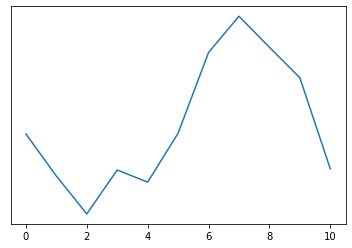

In [303]:
df = mean_target(train, "emp_length")

plt.yscale("logit")
plt.plot(df["emp_length"], df["mean_bad_loan"])

In [304]:
df

,emp_length,nrow,mean_bad_loan
0,NaN,0,0.264151
1,0.0,10727,0.180852
2,1.0,8506,0.176699
3,2.0,11877,0.173023
4,3.0,10243,0.177292
5,4.0,8285,0.176101
6,5.0,9313,0.180930
7,6.0,7472,0.189106
8,7.0,6766,0.192876
9,8.0,5584,0.189649


## 4. Combining Categories
### 4.1.  Combining Categories in Home Ownership

Although there are 6 recorded categories within home ownership, only three had over 200 observations: OWN, MORTGAGE, and RENT. The remaining three are so infrequent we will combine them {ANY, NONE, OTHER} with RENT to form an enlarged OTHER category. This new `home_ownership_3cat` variable will have values in {MORTGAGE, OTHER, OWN}.

In [305]:
mean_target(train, "home_ownership")

,home_ownership,nrow,mean_bad_loan
0,MORTGAGE,59901,0.162835
1,NONE,27,0.259259
2,OTHER,116,0.215517
3,OWN,10165,0.189670
4,RENT,52853,0.204284


In [306]:
lvls = ["OTHER", "MORTGAGE", "OTHER", "OTHER", "OWN", "OTHER"]
train["home_ownership_3cat"] = train["home_ownership"].set_levels(lvls).ascharacter().asfactor()

train[["home_ownership", "home_ownership_3cat"]].table()

home_ownership,home_ownership_3cat,Counts
MORTGAGE,MORTGAGE,59901
NONE,OTHER,27
OTHER,OTHER,116
OWN,OWN,10165
RENT,OTHER,52853


In [307]:
mean_target(train, "home_ownership_3cat")

,home_ownership_3cat,nrow,mean_bad_loan
0,MORTGAGE,59901,0.162835
1,OTHER,52996,0.204336
2,OWN,10165,0.189670


In [308]:
x_trans.remove("home_ownership")
x_trans.append("home_ownership_3cat")

# Step 5. Train Models using Transformed Data

The transformed variables are

In [309]:
x_trans

['emp_length',
 'te_purpose',
 'te_addr_state',
 'loan_amnt_core',
 'loan_amnt_delta',
 'annual_inc_core',
 'annual_inc_delta',
 'dti_core',
 'dti_delta',
 'delinq_2yrs_core',
 'delinq_2yrs_delta',
 'revol_util_0',
 'revol_util_core',
 'revol_util_delta',
 'total_acc_core',
 'total_acc_delta',
 'longest_credit_length_core',
 'longest_credit_length_delta',
 'term_60months',
 'verified',
 'emp_length_missing',
 'home_ownership_3cat']

We not fit a new set of models using AutoML

In [310]:
aml_trans = H2OAutoML(max_models = 6, exclude_algos = ['DeepLearning'])
aml_trans.train(x = x_trans, y = y, training_frame = train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [311]:
print(aml_trans.leaderboard)

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190809_200905,0.68349,0.44528,0.364896,0.37414,0.139981
StackedEnsemble_BestOfFamily_AutoML_20190809_200905,0.682609,0.445546,0.36643,0.374244,0.140059
GBM_1_AutoML_20190809_200905,0.681719,0.444415,0.367225,0.373932,0.139825
XGBoost_3_AutoML_20190809_200905,0.679835,0.445515,0.369837,0.374138,0.139979
XGBoost_1_AutoML_20190809_200905,0.679322,0.445255,0.36867,0.374358,0.140144
GLM_grid_1_AutoML_20190809_200905_model_1,0.676844,0.445642,0.371063,0.374368,0.140151
XGBoost_2_AutoML_20190809_200905,0.675382,0.446685,0.372382,0.374971,0.140603
DRF_1_AutoML_20190809_200905,0.662563,0.452761,0.381284,0.377448,0.142467


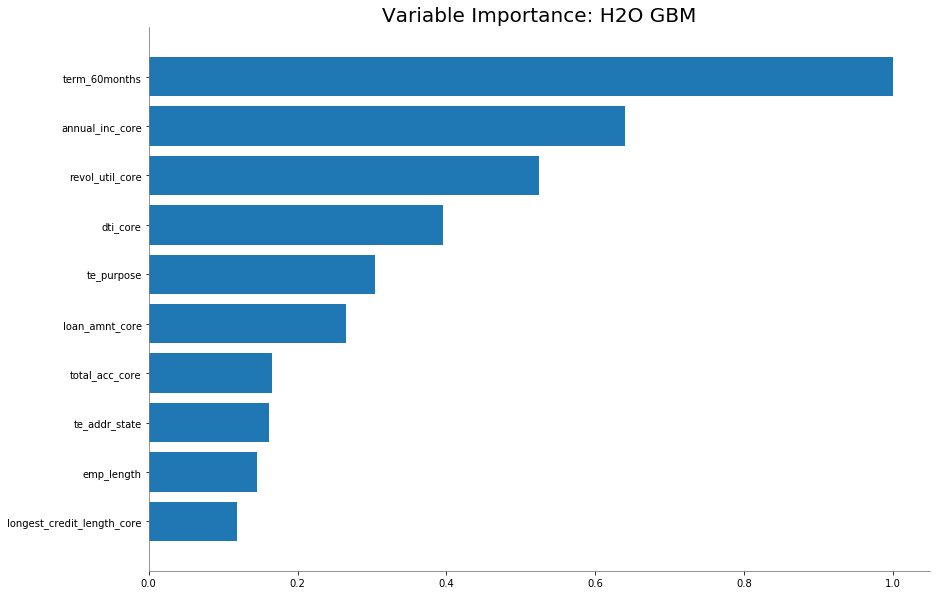

In [314]:
best_model_trans = h2o.get_model(aml_trans.leaderboard[2,'model_id'])
best_model_trans.varimp_plot()

In [315]:
print("AUC (orig): train = {:.4f}, xval = {:.4f}" \
      .format(best_model.auc(train = True),
              best_model.auc(xval = True)))

AUC (orig): train = 0.7216, xval = 0.6830


# Step 6 (of 6). Shutdown H2O Cluster

In [316]:
h2o.cluster().shutdown()

H2O session _sid_9b86 closed.
